In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import seaborn as sns
from scipy.linalg import fractional_matrix_power
import psutil
import os
import scipy.signal
import scipy.fftpack
import jax
import jax.numpy as jnp
from jax.lax import scan
import pickle
import uuid 
import glob
import scipy

N: 100
loss 1.0
1.0
distance between the two highest maxima:  3.3306690738754696e-16
root of N (number of iterations):  10.0
root of n (number of states):  10.0


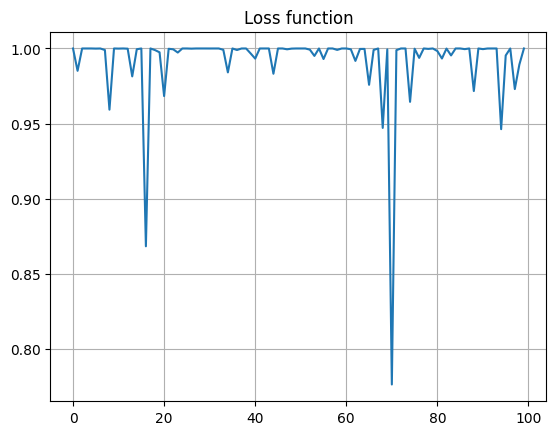

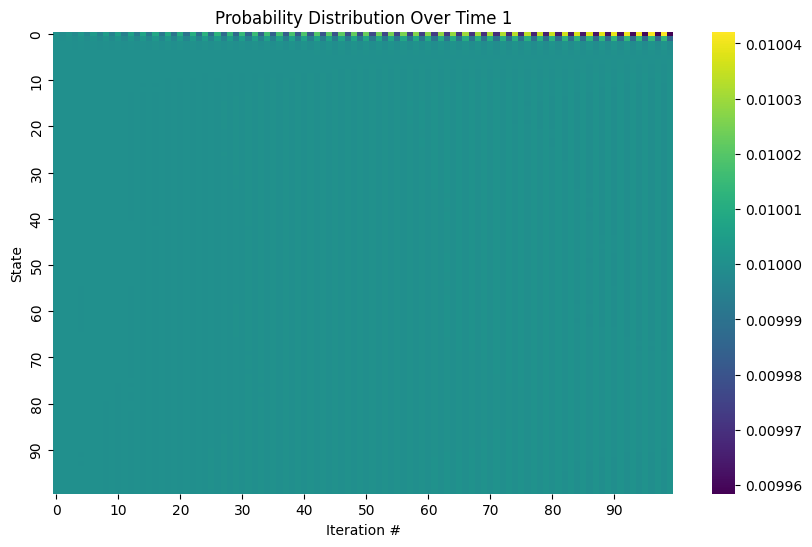

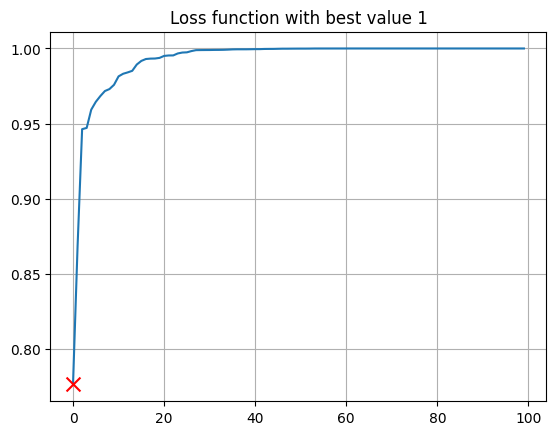

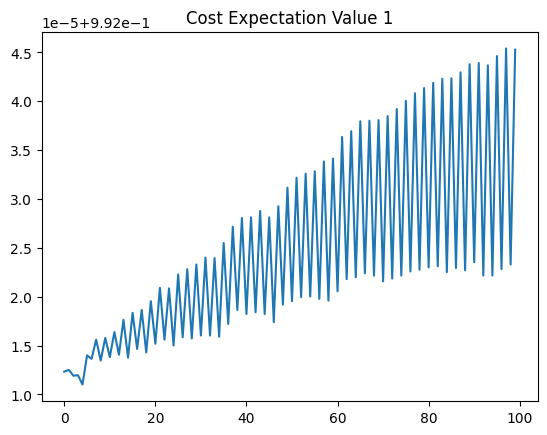

In [10]:
def hypercube(n):
    X = np.array([[0, 1], [1, 0]])
    dim = 2**n
    H = np.zeros((dim, dim), dtype=np.float64)

    # Sum the tensor products for each term in the Hamiltonian
    for i in range(n):
        # Create the term: I^{⊗ i} ⊗ X ⊗ I^{⊗ (N-i-1)}
        # create the list of matrices
        matrices = [np.eye(2)] * n
        matrices[i] = X  # Replace the i-th entry with the Pauli-X matrix
        
        # Take the tensor product of the matrices
        term = matrices[0]
        for j in range(1, n):
            term = np.kron(term, matrices[j])
        H -= term
    return H
def sigma_x_mixer(dim):
    X_mixer = np.zeros((dim, dim))
    
    for i in range(dim - 1):
        X_mixer[i, i+1] = 1  # Off-diagonal upper
        X_mixer[i+1, i] = 1  # Off-diagonal lower
    X_mixer[0][dim-1]=1
    X_mixer[dim-1][0]=1
    return X_mixer

def generate_loss_func(alpha, beta, n, scaling=1, set_distance_one=False):
    loss_func=np.random.beta(alpha, beta, size=n)
    #loss_func*=0.5
    if set_distance_one==True:
        loss_func[0]=1
        loss_func[-1]=1
    #loss_func[-1]=1
    loss_func*=scaling
 
    return loss_func   ########CHANGE BACK

@jax.jit
def grover_step(U, psi):
    psi_new = jnp.dot(U, psi)
    return psi_new, jnp.abs(psi_new) ** 2  

def grover_iter_jax(n, N, loss_func, k, t_param):
    loss_func_sort_idx = jnp.argsort(loss_func)
    loss_func_sort = loss_func[loss_func_sort_idx]


    plt.plot(loss_func)
    plt.title("Loss function")
    plt.grid()
    plt.show()

    # plt.plot(jnp.cumsum(loss_func_sort))
    # plt.title("Cumulative Loss function sorted")
    # plt.grid()
    # plt.show()
    X=sigma_x_mixer(n)
    #print(X)
    Mixer = scipy.linalg.expm(1j*X*t_param)
    
    oracle = jnp.diag(jnp.exp(1j * jnp.pi * loss_func_sort*t_param))
    psi_uniform = jnp.ones(n, dtype=jnp.complex64) / jnp.sqrt(n)
    D1 = 2 * jnp.outer(psi_uniform, psi_uniform) - jnp.eye(n, dtype=jnp.complex64)
    #print(D)
    D2= -1*jnp.eye(n, dtype=jnp.complex64) - (jnp.exp(-1j*jnp.pi*t_param)-1) *jnp.outer(psi_uniform, psi_uniform)
    #print(D)
    #print(oracle.shape)
    #print(Mixer.shape)
    U1 = D1 @ oracle  # Full Grover operator
    U2 = D2 @ oracle  # Full Grover operator
    U3 = Mixer @ oracle
    
    psi_init = jnp.array(psi_uniform, dtype=jnp.complex64)

    # Use JAX `scan` to apply Grover iterations efficiently
    psi_final1, prob_distr1 = scan(lambda psi, _: grover_step(U1, psi), psi_init, None, length=N)
    #psi_final2, prob_distr2 = scan(lambda psi, _: grover_step(U2, psi), psi_init, None, length=N)
    #psi_final3, prob_distr3 = scan(lambda psi, _: grover_step(U3, psi), psi_init, None, length=N)
    prob_distr1 = jnp.array(prob_distr1)
    # prob_distr2 = jnp.array(prob_distr2)
    # prob_distr3 = jnp.array(prob_distr3)
    #print(prob_distr3.T)
    #print("shape", prob_distr.shape)
    #print(prob_distr)
    plt.figure(figsize=(10, 6))
    sns.heatmap(prob_distr1.T, cmap="viridis", cbar=True, xticklabels=10, yticklabels=10)
    plt.xlabel("Iteration #")
    plt.ylabel("State")
    plt.title("Probability Distribution Over Time 1")
    plt.show()

    # plt.figure(figsize=(10, 6))
    # sns.heatmap(prob_distr2.T, cmap="viridis", cbar=True, xticklabels=10, yticklabels=10)
    # plt.xlabel("Iteration #")
    # plt.ylabel("State")
    # plt.title("Probability Distribution Over Time 2")
    # plt.show()
   
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(prob_distr3.T, cmap="viridis", cbar=True, xticklabels=10, yticklabels=10)
    # plt.xlabel("Iteration #")
    # plt.ylabel("State")
    # plt.title("Probability Distribution Over Time 2")
    # plt.show()

    best_indices1 = jnp.argsort(prob_distr1.max(axis=0))[::-1]
    # best_indices2 = jnp.argsort(prob_distr2.max(axis=0))[::-1]
    # best_indices3 = jnp.argsort(prob_distr3.max(axis=0))[::-1]
    
    plt.plot(loss_func_sort)
    plt.scatter(best_indices1[0], loss_func_sort[best_indices1[0]], color='red', s=100, marker='x', zorder=5)
    plt.title("Loss function with best value 1")
    plt.grid()
    plt.show()

    # plt.plot(loss_func_sort)
    # plt.scatter(best_indices2[0], loss_func_sort[best_indices2[0]], color='red', s=100, marker='x', zorder=5)
    # plt.title("Loss function with best value 2")
    # plt.grid()
    # plt.show()

    # plt.plot(loss_func_sort)
    # plt.scatter(best_indices3[0], loss_func_sort[best_indices3[0]], color='red', s=100, marker='x', zorder=5)
    # plt.title("Loss function with best value 3")
    # plt.grid()
    # plt.show()

    #print("shape",loss_func_sort.shape)
    #print(loss_func_sort)
    cost_exp_val1 = jnp.dot(prob_distr1, loss_func_sort)
    plt.plot(cost_exp_val1)
    plt.title("Cost Expectation Value 1")
    plt.show()

    # cost_exp_val2 = jnp.dot(prob_distr2, loss_func_sort)
    # plt.plot(cost_exp_val2)
    # plt.title("Cost Expectation Value 2")
    # plt.show()

    # FFT Analysis
    # fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # for i in range(k):
    #     label = f"k={i}"  

    #     k_exp = prob_distr.T[best_indices[i]] * loss_func_sort[best_indices[i]]
    #     k_prob = prob_distr.T[best_indices[i]]

    #     peaks_prob, _ = scipy.signal.find_peaks(k_prob)
    #     peak_distances_prob = jnp.diff(peaks_prob)  
    #     avg_dist_prob = jnp.mean(peak_distances_prob) if len(peak_distances_prob) > 0 else 0
        
    #     axes[0, 0].plot(k_exp, label=label)
    #     axes[0, 1].plot(k_prob, label=label)

    #     print(f"Peaks for Probability (k={i}): {peaks_prob}, Avg Distance: {avg_dist_prob:.2f}")

    #     k_exp_fft = jnp.abs(jnp.fft.fft(k_exp))
    #     freqs_exp = jnp.fft.fftfreq(len(k_exp))
    #     axes[1, 0].plot(freqs_exp[:len(freqs_exp)//2], k_exp_fft[:len(k_exp_fft)//2], label=label)

    #     k_prob_fft = jnp.abs(jnp.fft.fft(k_prob))
    #     freqs_prob = jnp.fft.fftfreq(len(k_prob))
    #     axes[1, 1].plot(freqs_prob[:len(freqs_prob)//2], k_prob_fft[:len(k_prob_fft)//2], label=label)


    # axes[0, 0].set_title("Expected Value for best k probabilities")
    # axes[0, 1].set_title("Probability distribution for best k")
    # axes[1, 0].set_title("FFT of Expected Value")
    # axes[1, 1].set_title("FFT of Probability Distribution")

    # axes[0, 0].legend()
    # axes[0, 1].legend()
    # axes[1, 0].legend()
    # axes[1, 1].legend()
    # plt.tight_layout()
    # plt.show()

     






#t=1
n=100  #number of states
#N=int(np.sqrt(n)*(1/t))  #number of iterations
N=100
print("N:",N)
alpha=10
beta=0.1

loss_func= generate_loss_func(alpha, beta, n, set_distance_one=False)
loss_func_sort_idx = jnp.argsort(loss_func)
best= loss_func_sort_idx[-1]
print("loss",loss_func[best])
t=1/loss_func[best]
print(t)
t=0.01
loss_func_sort = loss_func[loss_func_sort_idx]
print("distance between the two highest maxima: ", loss_func_sort[-1]-loss_func_sort[-2])
print("root of N (number of iterations): ",np.sqrt(N))
print("root of n (number of states): ",np.sqrt(n))
#grover_iter_test(n, N, loss_func)  #plots heatmap
 
grover_iter_jax(n, N, loss_func, 10, t)